In [11]:
from pecebl.designer import designer as pg
from pecebl.psf_import.casino import Casino3 as cs3
from pecebl.sem import supra40 as beamer

from pecebl.utils import *

import imageio

## 1) prepare PSF data
SEM : voltage and aperture

Beam writer : speed (Hz)

Monte-Carlo data: import psf file *zep520_1e7_30kV_100mrad_1pt* from Casino3

In [12]:
meb = beamer.Supra40(30) #we use a sem Zeiss Supra40 at 30kV
meb.change_aperture(7.5) #use the 7.5 µm aperture
meb.info()

SEM info:
current aperture size: 7.5 µm
current voltage: 30 kV
beam current: 28 pA



In [13]:
# import data from Casino3 software
filename='data/zep520_1e7_30kV_100mrad_1pt' 
sim=cs3(filename)

# the data is simulated with 1e7 electrons
# the ElphyPlus has 6 MHz of speed
# iy, i_y  = 3, 3 : we are at the peak of the psf and at the mid-depth of the ebeam resist
psf_fct=get_psf_fct(1e7, sim, 6, meb.beam_current, i_y=3, i_z=3)

In [14]:
# number of pixels and WF size:
n=4
NP=n*512;WF=5000

pixel_centered=True #True: (0,0) is in the [NP/2,NP/2] indices.
pixel_size=np.float32(WF/NP) if pixel_centered else np.float32(WF/(NP-1))

In [15]:
#to avoid
#RuntimeError: Numba cannot operate on non-primary CUDA context
#when using pycuda.

if 'pycuda_used' in locals():
    if pycuda_used:
        fft.cudadriver.Context.pop()

from pecebl.ebl_kernels import kernels as ker

#Map the PSF to 2D-array:
z_psf=ker.build_psf(psf_fct, NP, WF, pixel_size, pg.dot(0,0)[0], blockdim=(32,16))
numba_used = True

#padded psf for even NP:
ppsf=np.empty((NP,NP),np.float64)
ppsf[:NP//2-1,NP//2+1:]=z_psf[NP//2+1:,:NP//2-1]
ppsf[:NP//2-1,:NP//2+1]=z_psf[NP//2+1:,NP//2-1:]
ppsf[NP//2-1:,:NP//2+1]=z_psf[:NP//2+1,NP//2-1:]
ppsf[NP//2-1:,NP//2+1:]=z_psf[:NP//2+1,:NP//2-1]

del z_psf

z_PSF created on GPU in 0.102246 s
min value = 0.0; max value = 0.19314753448505648; sum value = 40.45887546800713.
  Total Memory: 2048 MiB
  Free Memory: 1470 MiB


## 2) Import target exposure
To simplify, the target exposure is given here in the filename *target_ebl_for_pec.npy*. This is the ideal exposure that we want to reach but don't know what dose to use.

But you can create your own target exposure (some suggestions to get the target exposure are in another demo)

In [16]:
import zipfile
zfile = zipfile.ZipFile("data/target_ebl_for_pec.zip","r")
with zfile as zip_ref:
    zip_ref.extractall()

In [17]:
z_target=np.load(zfile.namelist()[-1])

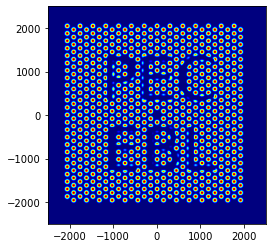

In [18]:
plt.imshow(z_target,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

## 3) PEC by FFT deconvolution
Deconvolution by FFT principe:
 - apply FFT to the convolution kernel psf (padded)
 - apply inverse Hadamard product to the previous result
 - apply FFT to the target exposure expo_t
 - perform the point-wise multiplication of the two preceding results
 - apply inverse FFT to the result of the multiplication

In [19]:
#to avoid
#LogicError: explicit_context_dependent failed: invalid device context - no currently active context?
#when reuse pycuda after using numba cuda.

from pycuda.tools import make_default_context

if 'numba_used' in locals() and 'pycuda_used' in locals():
    if numba_used and pycuda_used:
        make_default_context()

from pecebl.fft_ops import fft_ops as fft

pec = fft.fft_pec(ppsf,z_target)
pycuda_used = True

GPU : FFT(psf) = psf in-place fft..
CPU : 1/FFT(psf)...
GPU : FFT(T) = z_target in-place fft..
GPU : point-wise multiplication of two matrices...
GPU : inverse FFT to get dose distribution...
deconvolution done on GPU in 3.906357 s
54.1 % of device memory is free.
63.5 % of device memory is free.


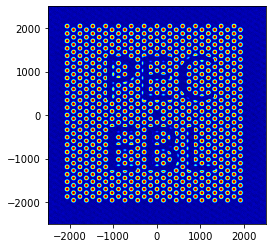

In [20]:
# plotting...
plt.imshow(pec.real,origin='upper', extent=[-WF/2, WF/2, -WF/2, WF/2],interpolation="nearest", cmap=plt.cm.jet)
plt.show()

**Note**: the pec found by FFT deconvolution may contain negative values. We will disscuss further some suggestions to solve this issue.

Now we can do the ebl exposure process with the pec dose distribution. We must recover the z_target.